In [9]:
import os
import argparse
import time
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.autograd import Variable
from models import FFDNet
from utils import *
import matplotlib.pyplot as plt
# from utils import batch_psnr, normalize, init_logger_ipol, \
#                 variable_to_cv2_image, remove_dataparallel_wrapper, is_rgb

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [29]:
def test_image(model, img_path, add_noise, noise_sigma):

    imorig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    imorig = np.expand_dims(imorig, 0)
    imorig = np.expand_dims(imorig, 0)

    # Handle odd sizes
    expanded_h = False
    expanded_w = False
    sh_im = imorig.shape
    if sh_im[2]%2 == 1:
        expanded_h = True
        imorig = np.concatenate((imorig, \
                imorig[:, :, -1, :][:, :, np.newaxis, :]), axis=2)

    if sh_im[3]%2 == 1:
        expanded_w = True
        imorig = np.concatenate((imorig, \
                imorig[:, :, :, -1][:, :, :, np.newaxis]), axis=3)

    imorig = normalize(imorig)
    imorig = torch.Tensor(imorig)

    dtype = torch.FloatTensor

    # Add noise
    if add_noise:
        noise = torch.FloatTensor(imorig.size()).\
                normal_(mean=0, std=noise_sigma)
        imnoisy = imorig + noise
    else:
        imnoisy = imorig.clone()

        # Test mode
    with torch.no_grad(): # PyTorch v0.4.0
        imorig, imnoisy = Variable(imorig.type(dtype)), \
                        Variable(imnoisy.type(dtype))
        nsigma = Variable(
                torch.FloatTensor([noise_sigma]).type(dtype))

    # Measure runtime
    start_t = time.time()

    # Estimate noise and subtract it to the input image
    im_noise_estim = model(imnoisy, nsigma)
    outim = torch.clamp(imnoisy-im_noise_estim, 0., 1.)
    stop_t = time.time()

    if expanded_h:
        imorig = imorig[:, :, :-1, :]
        outim = outim[:, :, :-1, :]
        imnoisy = imnoisy[:, :, :-1, :]

    if expanded_w:
        imorig = imorig[:, :, :, :-1]
        outim = outim[:, :, :, :-1]
        imnoisy = imnoisy[:, :, :, :-1]

    # Compute PSNR and log it

    print("### Grayscale denoising ###")
    print()
    if add_noise:
        psnr = batch_psnr(outim, imorig, 1.)
        psnr_noisy = batch_psnr(imnoisy, imorig, 1.)
        print("\tPSNR noisy {0:0.2f}dB".format(psnr_noisy))
        print("\tPSNR denoised {0:0.2f}dB".format(psnr))
    else:
        print("\tNo noise was added, cannot compute PSNR")
    print("\tRuntime {0:0.4f}s".format(stop_t-start_t))

    # Compute difference


    # Save images
    plt.figure(figsize=(15, 5))
    plt.subplot(1,3,1)
    plt.imshow(variable_to_cv2_image(imorig),cmap='gray')
    plt.axis('off')
    plt.title('clean image')
    plt.subplot(1,3,2)
    plt.imshow(variable_to_cv2_image(imnoisy),cmap='gray')
    plt.axis('off')
    plt.title('noisy image')
    plt.subplot(1,3,3)
    plt.imshow(variable_to_cv2_image(outim),cmap='gray')
    plt.axis('off')
    plt.title('denoised image,ffdnet')
    plt.show()
    return psnr

### Grayscale denoising ###

	PSNR noisy 9.05dB
	PSNR denoised 16.47dB
	Runtime 0.2148s


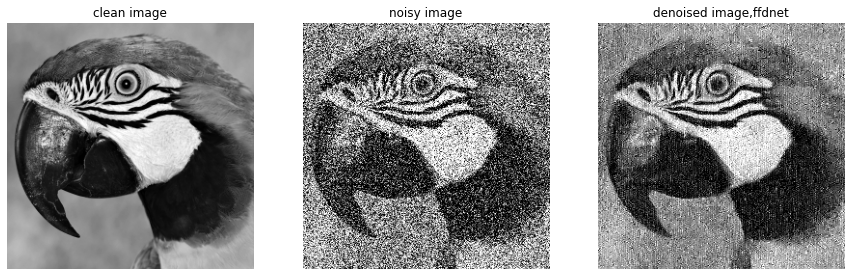

In [36]:
test_images_file = 'bird_img'
img_files = os.listdir(test_images_file)
add_noise = True
noise_sigma = 90

in_ch = 1
model_fn = 'logs/net.pth'
model_fn = os.path.join(os.getcwd(), \
                model_fn)
net = FFDNet(num_input_channels=in_ch)
state_dict = torch.load(model_fn, map_location='cpu')
state_dict = remove_dataparallel_wrapper(state_dict)
model = net
model.load_state_dict(state_dict)
model.eval()

noise_sigma /= 255.
psnr = 0
for img in img_files:
    if img == '.DS_Store':
        continue
    psnr += test_image(model, test_images_file+'/'+img, add_noise, noise_sigma)
# print('Average PSNR: ' + str(psnr/len(img_files)))